# EDA for Dropped California Fire Data

Modules: N/A <br>
Author: Jordan Meyer <br>
Email: jordan.meyer@berkeley.edu <br>
Date created: February 25, 2023 <br>

**Citations (data sources)**

``CA fires data:``
1. CAL Fire: Fire perimeters database: https://frap.fire.ca.gov/mapping/gis-data/
2. Data dictionary: https://frap.fire.ca.gov/frap-projects/fire-perimeters/

Layer 0 - accidental wildfires
Layer 1 - prescribed fires 
Layer 2 - non-prescribed fire fuel reduction projects

``Shapefiles for California ZIP codes (2010 census):``

Note: CAL Fire also has county bounderies info (check it here: https://frap.fire.ca.gov/mapping/gis-data/)

3. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=ZIP+Code+Tabulation+Areas

4. How to find if a point is inside a polygon:<br>
https://stackoverflow.com/questions/43892459/check-if-geo-point-is-inside-or-outside-of-polygon <br>
https://medium.com/analytics-vidhya/point-in-polygon-analysis-using-python-geopandas-27ea67888bff
    
**Citations (persons)**
1. N/A

**Preferred environment**
1. Code written in Jupyter Notebooks

### Step 1: Import packages

In [8]:
import cartopy.crs as ccrs
import contextily as ctx
import fiona
import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import netCDF4 as ncdf
import numpy as np
import os
import osmnx
import pandas as pd
import shapely
import sklearn.metrics
import warnings
warnings.filterwarnings(
    'ignore'
)


from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from shapely.geometry import MultiPolygon, Polygon, Point

dist = sklearn.metrics.DistanceMetric.get_metric(
    'haversine'
)

### Step 2: Read cleaned data

```read data```

In [9]:
# 
# import shapely.wkt as wkt

# # read in the cleaned data and set index
# df = pd.read_csv('fires_clean.csv', index_col='Index')
# df['geometry'] = df['geometry'].apply(wkt.loads)
# df['fire_centroid'] = df['fire_centroid'].apply(wkt.loads)
# data = gpd.GeoDataFrame(df, crs='epsg:4326')

# data["lon"] = data['fire_centroid'].map(lambda p: p.x)
# data["lat"] = data['fire_centroid'].map(lambda p: p.y)
# data['year'] = data['ALARM_DATE'].str[:4]
# data['year_month'] = data['ALARM_DATE'].str[:4] + data['ALARM_DATE'].str[5:7]
# data['year']=data['year'].astype(int)
# data = data[data['year'] > 1990]

# data.to_csv("fire_as_pandas.csv")

In [10]:
df = pd.read_csv("fire_as_pandas.csv",index_col=0)
df.head()

,FIRE_NAME,ALARM_DATE,CONT_DATE,CAUSE,GIS_ACRES,Shape_Length,Shape_Area,geometry,fire_centroid,DURATION,FIRE_AREA_KM2,lon,lat,year_month,year
Index,,,,,,,,,,,,,,,
0,NELSON,2020-06-18,2020-06-23,11.0,109.602280,3252.523280,4.435447e+05,MULTIPOLYGON (((-121.3484028087498 38.88998578...,POINT (-121.3480590211847 38.88804091206984),5 days,0.443546,-121.348059,38.888041,202006,2020
1,AMORUSO,2020-06-01,2020-06-04,2.0,685.585022,9653.760308,2.774464e+06,MULTIPOLYGON (((-121.3527511981571 38.82038346...,POINT (-121.3708983104108 38.82756661261951),3 days,2.774464,-121.370898,38.827567,202006,2020
3,FLEMING,2020-03-31,2020-04-01,9.0,12.931545,1577.155857,5.233211e+04,MULTIPOLYGON (((-121.2731671002445 38.96307664...,POINT (-121.2734135751918 38.9623284462546),1 days,0.052332,-121.273414,38.962328,202003,2020
4,MELANESE,2020-04-14,2020-04-19,18.0,10.315964,1035.787625,4.174722e+04,MULTIPOLYGON (((-121.300654144116 39.487136507...,POINT (-121.3006534927401 39.48636412414794),5 days,0.041747,-121.300653,39.486364,202004,2020
5,PFE,2020-07-05,2020-07-05,14.0,36.701931,2348.114043,1.485274e+05,MULTIPOLYGON (((-121.3823786350436 38.72932784...,POINT (-121.3810176618852 38.73133921489409),0 days,0.148527,-121.381018,38.731339,202007,2020


In [11]:
in_dir_zip_shapes = '../wind/tl_2010_06_zcta510/'
in_dir = '../wind/ca only/'
in_health = 'health/'
out_dir = './'

In [12]:
zip_poly = pd.read_csv('zcta_census.csv', index_col=0)

In [13]:
zip_poly.head()

,lat,lon,ZCTA10,GEOID10
0,37.465,-117.936,89010,689010
1,37.465,-117.935,89010,689010
2,37.465,-117.934,89010,689010
3,37.465,-117.932,89010,689010
4,37.465,-117.926,89010,689010


In [14]:
def add_zcta_to_fire(df1, df2):
    '''
    params:
    -------
    df1: fire cleaned data
    df2: census geometry data
    
    return:
    -------
    '''
    
    # create labels
    df1['fire_lat_lon'] = [str(xy) for xy in zip(df1.lat, df1.lon)]
    df2['census_lat_lon'] = [str(xy) for xy in zip(df2.lat, df2.lon)]

    ## for each point in wind data find the nearest point in the census data ##
    ###############
    # keep only unique points in fire data
    df1_unique = df1.drop_duplicates(
        ['fire_lat_lon']
    
    )
    df2_unique = df2.drop_duplicates(
        ['census_lat_lon']
    )
    
    df1_unique.reset_index(
        drop=True,
        inplace=True
    )
    
    df2_unique.reset_index(
        drop=True,
        inplace=True
    )

    # transform to radians
    df1_unique['lat_r'] = np.radians(df1_unique.lat)
    df1_unique['lon_r'] = np.radians(df1_unique.lon)
    df2_unique['lat_r'] = np.radians(df2_unique.lat)
    df2_unique['lon_r'] = np.radians(df2_unique.lon)


    # compute pairwise distance (in miles)
    dist_matrix = (dist.pairwise(
        df1_unique[['lat_r', 'lon_r']],
        df2_unique[['lat_r', 'lon_r']]
    ))*3959
        
    # create a df from dist_matrix
    dist_matrix = pd.DataFrame(
        dist_matrix,
        index=df1_unique['fire_lat_lon'],
        columns=df2_unique['census_lat_lon']
    ) 
    # print(dist_matrix)
    
    # print('min id')
    # print(dist_matrix[dist_matrix.idxmin(axis=1)].min()[0])
    
    # for each row (census_lat_lon point) extract the closest column (fire_lat_lon point) 
    closest_point = pd.DataFrame(
        {'closest_zip_lat_lon':dist_matrix.idxmin(axis=1),
         'distance': dist_matrix[dist_matrix.idxmin(axis=1)].min()[0]
        }
    )
    
    closest_point.reset_index(
        drop=False,
        inplace=True
    )
 
    # merge with census data
    df1_unique = df1_unique.merge(
        closest_point,
        on='fire_lat_lon',
        how='left'
    )
    
    # merge with census data 
    df3 = df1_unique.merge(
        df2,
        left_on=['closest_zip_lat_lon'],
        right_on=['census_lat_lon'],
        how='left'
    )

#     df1 = df1[
#         ['FIRE_NAME', 'ALARM_DATE', 'CONT_DATE', 'GIS_ACRES',
#        'Shape_Length', 'Shape_Area', 'geometry', 'fire_centroid', 'DURATION',
#        'FIRE_AREA_KM2','fire_lat_lon']]
    
    
#     # merge df2_unique with df1
#     df2_unique = df2_unique.merge(
#         df1,
#         left_on=['census_lat_lon'],
#         right_on=['closest_zip_lat_lon'],
#         how='right'
#     )
    
    df1_unique.dropna(
        inplace=True
    )
    
    # df1_unique.reset_index(
    #     drop=True,
    #     inplace=True
    # )
    
#     df2_unique.drop_duplicates(
#     ['year_month', 'ZCTA10'],
#     inplace=True
#     )

    df2_unique.reset_index(
        drop=True,
        inplace=True
    )
    
    return df3

In [22]:
df_final = add_zcta_to_fire(df.head(4), zip_poly.head(100))

In [23]:
df_final.to_csv("fire_zips.csv")

In [24]:
df_final.shape

(4, 25)

In [25]:
df_final.drop_duplicates().head(4).T

,0,1,2,3
FIRE_NAME,NELSON,AMORUSO,FLEMING,MELANESE
ALARM_DATE,2020-06-18,2020-06-01,2020-03-31,2020-04-14
CONT_DATE,2020-06-23,2020-06-04,2020-04-01,2020-04-19
CAUSE,11.0,2.0,9.0,18.0
GIS_ACRES,109,685,12,10
Shape_Length,3252.52328,9653.760308,1577.155857,1035.787625
Shape_Area,443544.674795,2774464.034499,52332.108664,41747.224452
geometry,MULTIPOLYGON (((-121.3484028087498 38.88998578...,MULTIPOLYGON (((-121.3527511981571 38.82038346...,MULTIPOLYGON (((-121.2731671002445 38.96307664...,MULTIPOLYGON (((-121.300654144116 39.487136507...
fire_centroid,POINT (-121.3480590211847 38.88804091206984),POINT (-121.3708983104108 38.82756661261951),POINT (-121.2734135751918 38.9623284462546),POINT (-121.3006534927401 39.48636412414794)
DURATION,5 days,3 days,1 days,5 days


In [20]:
df['GIS_ACRES'] = df['GIS_ACRES'].astype(int)

In [ ]:
data[data['GIS_ACRES'] < 1000].count()

In [ ]:
data[data['GIS_ACRES'] > 1000].count()

In [ ]:
11087/(11087+1594)

In [ ]:
9962/(9962+2717)

87% of the dropped wildfires were relatively small, burning less than 2000 acres. 79% burned less than 1000 acres.

<Axes: ylabel='Density'>

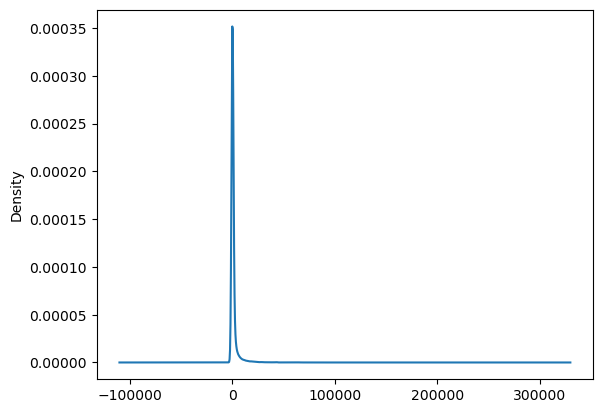

In [163]:
data['GIS_ACRES'].plot.kde()

<Axes: ylabel='Frequency'>

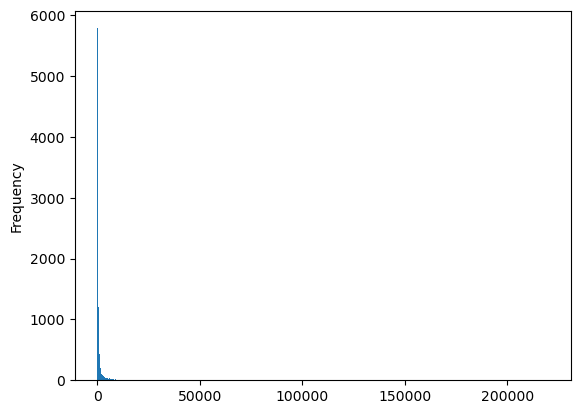

In [164]:
data['GIS_ACRES'].plot.hist(bins=1000)

(0.0, 10000.0)

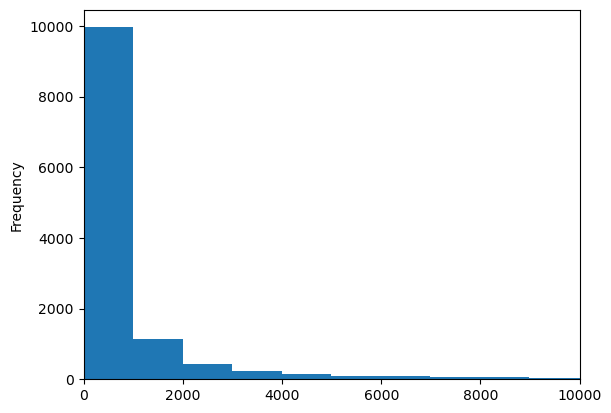

In [165]:
# plot fires less than 50,000 acres 
bulkacres = data[data.GIS_ACRES < 20000]
bulkacres['GIS_ACRES'].plot.hist(bins=20)
plt.xlim(0,10000)
#plt.ylim(0,1000)

<Axes: >

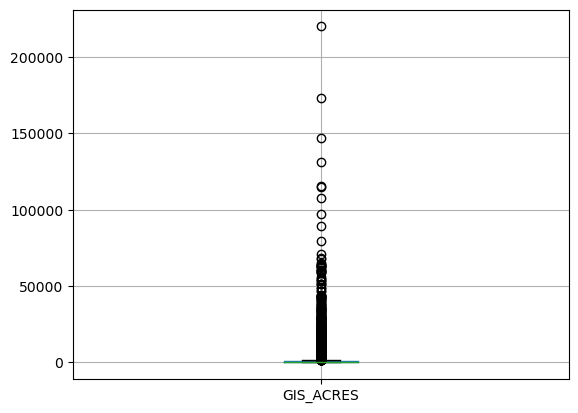

In [166]:
data.boxplot(column='GIS_ACRES')

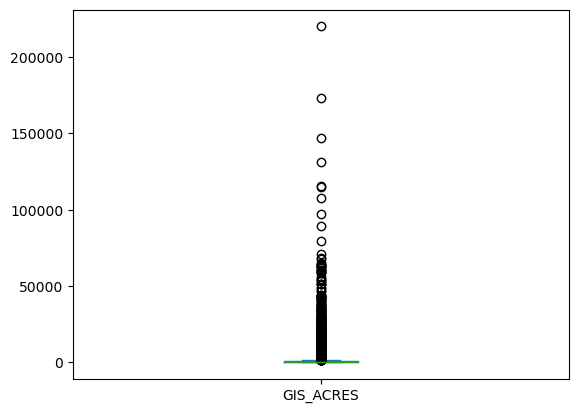

In [167]:
data['GIS_ACRES'].plot(kind='box');

In [195]:
outliers = data[data.GIS_ACRES > 10000]
outliers.sort_values(by=['GIS_ACRES'], ascending=False)
outliers.reset_index(inplace=True)

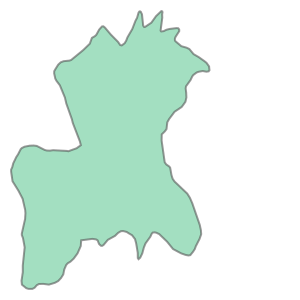

In [205]:
outliers.geometry[0]

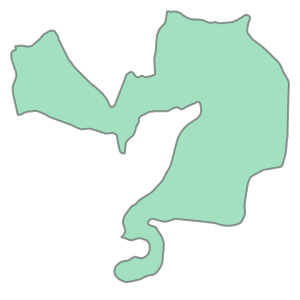

In [224]:
outliers.geometry[10]

The 5 largest dropped wildfires all occured before or during 1990

(-417478.5528250004, 555823.650125001, -657658.9472749997, 506831.4781750003)

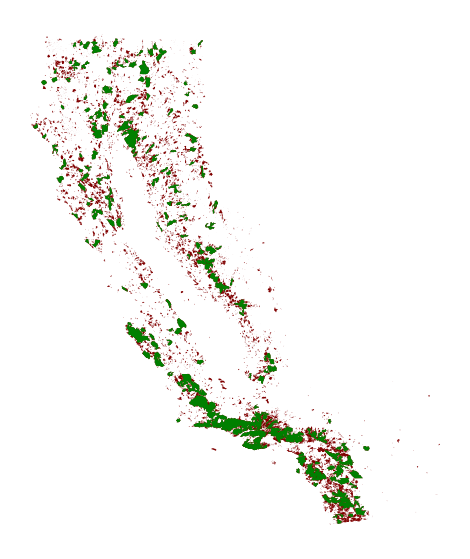

In [252]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(7,7))

data.geometry.plot(
    ax=ax,
    facecolor='maroon',
    aspect=1
)

outliers.geometry.plot(
    ax=ax,
    facecolor='green',
    aspect=1
)

# set axis off
ax.axis("off")

# plt.savefig(out_dir + "Fig3c.pdf")